In [27]:
 %matplotlib widget

import numpy as np
from numpy import cross, eye, dot
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
import time
import math
import scipy.constants as sc
from scipy.linalg import expm, norm
import pandas
from matplotlib.widgets import Slider, Button
import colorcet as cc
import numba as nb

# Three variables drawn from Gaussian distribution
def sample_spherical(npoints, ndim=3):
    vec = np.random.randn(ndim, npoints)
    vec /= np.linalg.norm(vec, axis=0)
    return vec

# Doppler shift a given angular frequency given angle to observer in source frame and observer's speed 
def doppler_shift(angFreq,obsAngle,obsSpeed):
    # obsAngFreq = angFreq*((np.sqrt(1-obsSpeed**2)/(1 - obsSpeed*np.cos(obsAngle)))) #old function—used wrong equation
    obsAngFreq = angFreq*((obsSpeed*np.cos(obsAngle)+1)/np.sqrt(1-obsSpeed**2))
    return obsAngFreq

def ang_freq_to_lambda(omega):
    wavelength = sc.c/(2*math.pi*omega)
    return wavelength

def lambda_to_ang_freq(wavelength):
    omega = sc.c/(2*math.pi*wavelength)
    return omega

def vectors_angle(v1, v2):
    if (np.dot(v1, v2))/(np.linalg.norm(v1)*np.linalg.norm(v2)) <= 1 and (np.dot(v1, v2))/(np.linalg.norm(v1)*np.linalg.norm(v2)) >= -1:
        return math.acos((np.dot(v1, v2))/(np.linalg.norm(v1)*np.linalg.norm(v2)))
    elif (np.dot(v1, v2))/(np.linalg.norm(v1)*np.linalg.norm(v2)) < -1:
        print('Less:' + str((np.dot(v1, v2))/(np.linalg.norm(v1)*np.linalg.norm(v2))))
        return math.acos(-1)
    elif (np.dot(v1, v2))/(np.linalg.norm(v1)*np.linalg.norm(v2)) > 1:
        print('Greater:' + str((np.dot(v1, v2))/(np.linalg.norm(v1)*np.linalg.norm(v2))))
        return math.acos(1)

# def vectors_angle(v1,v2):
#     angle = math.acos((np.dot(v1,v2))/(np.linalg.norm(v1)*np.linalg.norm(v2)))
#     return angle

def abberation_angle(angle,obsSpeed):
    abberationAngle = math.acos((obsSpeed + math.cos(angle))/(obsSpeed*math.cos(angle)+1))
    return abberationAngle

def unit_norm_vector(v1,v2):
    normVector = np.cross(v1,v2)
    unitNormVector = normVector/np.linalg.norm(normVector)
    return unitNormVector

def rotateMatrix(axis,angle):
    rotatedMatrix = expm(cross(eye(3), axis/norm(axis)*angle))
    return rotatedMatrix

def wavelength_to_rgb(wavelength, gamma=0.8):
    '''This converts a given wavelength of light to an 
    approximate RGB color value. The wavelength must be given
    in nanometers in the range from 380 nm through 750 nm
    (789 THz through 400 THz).

    Based on code by Dan Bruton
    http://www.physics.sfasu.edu/astro/color/spectra.html
    '''

    wavelength = float(wavelength)
    if wavelength >= 380 and wavelength <= 440:
        attenuation = 0.3 + 0.7 * (wavelength - 380) / (440 - 380)
        R = ((-(wavelength - 440) / (440 - 380)) * attenuation) ** gamma
        G = 0.0
        B = (1.0 * attenuation) ** gamma
    elif wavelength >= 440 and wavelength <= 490:
        R = 0.0
        G = ((wavelength - 440) / (490 - 440)) ** gamma
        B = 1.0
    elif wavelength >= 490 and wavelength <= 510:
        R = 0.0
        G = 1.0
        B = (-(wavelength - 510) / (510 - 490)) ** gamma
    elif wavelength >= 510 and wavelength <= 580:
        R = ((wavelength - 510) / (580 - 510)) ** gamma
        G = 1.0
        B = 0.0
    elif wavelength >= 580 and wavelength <= 645:
        R = 1.0
        G = (-(wavelength - 645) / (645 - 580)) ** gamma
        B = 0.0
    elif wavelength >= 645 and wavelength <= 750:
        attenuation = 0.3 + 0.7 * (750 - wavelength) / (750 - 645)
        R = (1.0 * attenuation) ** gamma
        G = 0.0
        B = 0.0
    else:
        R = 0.0
        G = 0.0
        B = 0.0
    R *= 255
    G *= 255
    B *= 255
    return [int(R), int(G), int(B)]

def determineAngleToObs(obsVector, xi, yi, zi):
    # angles between all vectors and observer vector from dot product
    angles = []
    for i in range(0, len(xi)):
        angles.append(vectors_angle(obsVector, (xi[i], yi[i], zi[i])))
    return angles

# NEW ANGLE FUNCTION
#You can disable parallelization with parallel=False
@nb.njit(fastmath=True,error_model="numpy",parallel=False)
def angle_fast(v1,v2):
    #Check the dimensions, this may also have an effect on SIMD-vectorization
    assert v1.shape[1]==3
    assert v2.shape[1]==3
    res=np.empty(v1.shape[0])

    for i in nb.prange(v1.shape[0]): #v2 is now the observer vector
        dot=0.
        a=0.
        b=0.
        for j in range(3):
            dot+=v1[i,j]*v2[0,j]
            a+=v1[i,j]**2
            b+=v2[0,j]**2
        res[i]=np.arccos(dot/(np.sqrt(a*b)))
        # for j in range(3):
        #     dot+=v1[i,j]*v2[i,j]
        #     a+=v1[i,j]**2
        #     b+=v2[i,j]**2
        # res[i]=np.arccos(dot/(np.sqrt(a*b)))
    return res

def restLambdaToObsLambda(restLambda, angles, obsSpeed):
    # lambda values as perceived by moving observer
    restAngFreq = lambda_to_ang_freq(restLambda)
    obsLambda = (ang_freq_to_lambda(doppler_shift(restAngFreq, angles, obsSpeed)))
    return obsLambda

def wavelengthToRGB(obsLambda):
    RGBs = []
    for i in range(0, len(obsLambda)):
        RGBs.append(wavelength_to_rgb(obsLambda[i]))
    RGBs = np.asarray(RGBs, dtype=np.float32)
    return RGBs

def updatePoints(angles, obsSpeed, obsVector, xi, yi, zi):
    ## Now we try to congregate points along the source of motion due to abberation
    # angle difference
    deltaAngles = []
    for i in range(0, len(angles)):
        deltaAngles.append(-(abberation_angle(angles[i], obsSpeed) - angles[i]))
    # normal vector/rotation axes
    rotAxes = []
    for i in range(0, len(angles)):
        rotAxes.append(unit_norm_vector((xi[i], yi[i], zi[i]), obsVector))
    rotationMatrices = []
    for i in range(0, len(rotAxes)):
        rotationMatrices.append(rotateMatrix(rotAxes[i], deltaAngles[i]))
    rotatedPoints = []
    for i in range(0, len(rotationMatrices)):
        rotatedPoints.append(dot(rotationMatrices[i], (xi[i], yi[i], zi[i])))
    rotatedPoints = np.asarray(rotatedPoints, dtype=np.float32)
    return rotatedPoints

def transformedPoints(obsSpeed,obsVector,restLambda,initialPointsVectors):
    angles = angle_fast(initialPointsVectors,obsVector)
    # angles = determineAngleToObs(obsVector,xi,yi,zi)
    obsLambda = restLambdaToObsLambda(restLambda,angles,obsSpeed)*10**9
    RGBs = wavelengthToRGB(obsLambda)
    rotatedPoints = updatePoints(angles,obsSpeed,obsVector,xi,yi,zi)
    return rotatedPoints, RGBs, obsLambda

def cart2sph(obsVector):
    hxy = np.hypot(obsVector[0],obsVector[1])
    if obsVector[2] == 0:
        theta = np.pi/2
    else:
        theta = np.arccos(obsVector[2]/math.sqrt(obsVector[0]**2 + obsVector[1]**2 + obsVector[2]**2))
    if obsVector[0] > 0:
        atan = np.arctan(obsVector[1]/obsVector[0])
        phi = atan
    elif obsVector[0] < 0 and obsVector[1] >= 0:
        atan = np.arctan(obsVector[1]/obsVector[0])
        phi = atan + np.pi
    elif obsVector[0] < 0 and obsVector[1] < 0:
        atan = np.arctan(obsVector[1]/obsVector[0])
        phi = atan - np.pi
    elif obsVector[0]==0 and obsVector[1] > 0:
        phi = np.pi/2
    elif obsVector[0]==0 and obsVector[1] < 0:
        phi = -np.pi/2
    elif obsVector[0] == 0 and obsVector[1] == 0:
        phi = 0
    return (theta, phi)

def sph2cart(obsPolar): #r=1
    x = np.sin(obsPolar[0]) * np.cos(obsPolar[1])
    y = np.sin(obsPolar[0]) * np.sin(obsPolar[1])
    z = np.cos(obsPolar[0])
    return (x, y, z)

def NormalizeData(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))

In [70]:
import scipy.stats as sts
import dynesty
import time
from dynesty import plotting as dyplot
from numpy import *
import multiprocess

sigma = 0.1
restLambda = ang_freq_to_lambda(1)  # define ang_freq to be 1.
obsPolar = (0.7, 4)
observerVector = sph2cart(obsPolar)
observerVector2 = np.asarray([observerVector]) # plays nice with the new angle function
time_taken = []
pol_true, az_true = obsPolar
logZ = []
log_Z0 = []
log_ZCMB = []
omega_val = 1

points = []

for i in np.linspace(0, 5, 11):
    points.append(int(10**i)) # logarithmically spaced points
points.append(300000)
points.append(500000)

for n in [100000]: # number of points to sample
    for obsSpeed in [0.001]:
        xi, yi, zi = sample_spherical(n)
        initialPointsVectors = np.asarray([xi, yi, zi]).T
        rotatedPoints, RGBs, obsLambda = transformedPoints(
            obsSpeed, observerVector2, restLambda, initialPointsVectors)
        rotatedPointVectors = np.asarray([rotatedPoints[0:len(
                        rotatedPoints), 0], rotatedPoints[0:len(rotatedPoints), 1], rotatedPoints[0:len(rotatedPoints), 2]]).T

        # list of Doppler shifted angular frequencies
        obsAngFreq = lambda_to_ang_freq(obsLambda*10**(-9))
        normalisedObsAngFreq = NormalizeData(obsAngFreq)
        
        t0 = time.time()
        ## dynesty model fitting
        omegas = lambda_to_ang_freq(obsLambda*10**(-9)) #convert obsLambda in nm to m, then to angular frequency
        omega_error = np.random.normal(loc=0, scale=sigma, size=len(omegas))
        omega_new = omegas + omega_error

        #change model to accept v, az, pol
        def model(v, az, pol):
            observerVector = sph2cart((pol, az))
            observerVector2 = np.asarray([observerVector])
            alphaDash = angle_fast(rotatedPointVectors, observerVector2)
            # alphaDash = determineAngleToObs(observerVector,rotatedPoints[0:len(rotatedPoints),0], rotatedPoints[0:len(rotatedPoints),1], rotatedPoints[0:len(rotatedPoints),2])
            model = lambda_to_ang_freq(restLambda)*(np.sqrt(1-v**2)/(1-v*np.cos(alphaDash)))
            return model

        def prior_transform(uTheta):
            uV, uAz, uPol = uTheta
            v = 0.01*uV # uniform between 0 and 0.01
            az = 2*np.pi*uAz # uniform between 0 and 2*pi
            pol = np.pi*uPol # uniform between 0 and pi
            return v, az, pol
        
        def lnlike(Theta):
            v, az, pol = Theta
            # turn az and pol into alpha' for this omega
            omega_val = model(v,az,pol)
            return sum(sts.norm.logpdf(omega_new,loc=omega_val,scale=sigma))
        
        with multiprocess.Pool(8) as pool:
            dsampler = dynesty.DynamicNestedSampler(lnlike, prior_transform, ndim=3,pool=pool,queue_size=8)
            dsampler.run_nested()
            dresults = dsampler.results
        
        t1 = time.time()

        total = t1 - t0
        time_taken.append(total)

        v_true = obsSpeed
        fig, axes = dyplot.cornerplot(dresults, truths=[v_true, az_true, pol_true], show_titles=True, title_kwargs={
                                      'y': 1.04}, labels=['$v$', '$\phi$', '$\\theta$'], title_fmt='.3f')
        plt.savefig('corner-tau-n' + str(n) + '-v' + str(obsSpeed) + '-s' + str(sigma) + '.pdf')

        ## Evidences
        lnZ = dresults.logz[-1] #select last element of cumulative log z array
        lnZ_err = dresults.logzerr[-1] #select last element of cumulative log z error array
        logZ.append(lnZ)

        omega_val = 1
        log_Z_0 = sum(sts.norm.logpdf(omega_new, loc=omega_val, scale=sigma))
        log_Z0.append(log_Z_0)
        
        pol, az, v = np.pi/2 - (48.253*np.pi/180), 246.021 * \
            np.pi/180, (369.82*1000)/sc.c

        CMBDipoleVector = sph2cart((pol, az))
        CMBDipoleVector2 = np.asarray([CMBDipoleVector])

        rotatedPointsVectors = np.asarray([rotatedPoints[0:len(
            rotatedPoints), 0], rotatedPoints[0:len(rotatedPoints), 1], rotatedPoints[0:len(rotatedPoints), 2]]).T  # as above

        alphaDash_CMB = angle_fast(rotatedPointsVectors, CMBDipoleVector2)
        omega_val_CMB = 1 * \
            (np.sqrt(1-v**2))/(1-v*np.cos(alphaDash_CMB))

        log_Z_CMB = sum(sts.norm.logpdf(omega_new, loc=omega_val_CMB, scale=0.01*sigma))
        log_ZCMB.append(log_Z_CMB)
        
        # print("log(Z_CMB) = {0:1.1f}".format(log_Z_CMB))

        # CMBDipoleVector = sph2cart((pol, az))
        # alphaDash = determineAngleToObs(CMBDipoleVector, rotatedPoints[0:len(
        #     rotatedPoints), 0], rotatedPoints[0:len(rotatedPoints), 1], rotatedPoints[0:len(rotatedPoints), 2])
        # omega_val = lambda_to_ang_freq(restLambda) * \
        #     (np.sqrt(1-v**2)/(1-v*np.cos(alphaDash)))
        # log_Z_CMB = sum(sts.norm.logpdf(omega_new, loc=omega_val, scale=sigma))
        # log_ZCMB.append(log_Z_CMB)


0it [00:00, ?it/s]


ValueError: The log-likelihood (nan) of live point 346 located at u=[0.37410539 0.75806593 0.74618604] v=[3.74105388e-03 4.76306873e+00 2.34421257e+00]  is invalid.

In [38]:
import pandas as pd

n = [1,3,10,31,100,316,1000,3162,10000]

values = np.stack((n,time_taken,logZ,log_Z0,log_ZCMB),axis=1)

index = ['# points','Time taken','logZ','logZ_0','logZ_CMB']
df = pd.DataFrame(data=values, columns=index)

df.to_csv('round5b.csv')

In [59]:
df1 = pd.read_csv('round5a.csv')
df2 = pd.read_csv('round5b.csv')

df_round1 = pd.read_csv('round1.csv')

df_round5 = pd.concat([df2,df1])

n5 = np.asarray(df_round5['# points'])
time_taken5 = np.asarray(df_round5['Time taken'])

n1 = np.asarray(df_round1['# points'])
time_taken1 = np.asarray(df_round1['Time taken'])

# Time Complexity

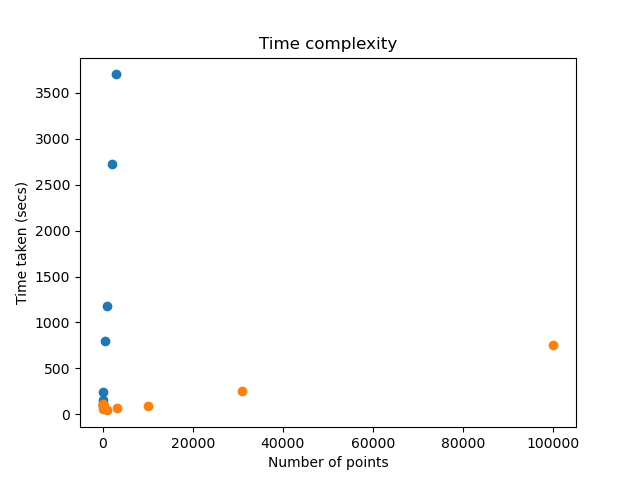

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


In [62]:
plt.figure()
ax = plt.gca()
plt.scatter(n1,time_taken1)
plt.scatter(n5,time_taken5)
plt.xlabel('Number of points')
plt.ylabel('Time taken (secs)')
plt.title('Time complexity')
# ax.set_yscale('log')
# ax.set_xscale('log')
plt.show()

# plt.plot(n, 3.08*x+7.7,label='$O(n)$')
# plt.plot(n,x*np.log(0.01*x+4.28),label='$O(n\,\log n)$')
# plt.plot(n,0.0008*x**2+1.73*x+55,label='$O(n^2)$')

plt.legend()

In [82]:
import scipy.stats as sts

x = np.asarray(n)

def model(x, m, b):
    model = m*x + b
    return model


# parameter theta drawn uniform distribution between zero and one.
def prior_transform(utheta):
    um, ub = utheta
    m = 10*um  # prior: m is between 0 and 10
    b = 100*ub  # prior: b is between 0 and 10
    return m, b


def lnlike(params):  # same parameter function?
    m, b = params
    y_val = model(x, m, b)
    return sum(sts.norm.logpdf(time_taken, loc=y_val, scale=100))


dsampler = dynesty.DynamicNestedSampler(lnlike, prior_transform, ndim=2)
dsampler.run_nested()
dresults = dsampler.results


20142it [01:26, 231.90it/s, batch: 10 | bound: 60 | nc: 21 | ncall: 79202 | eff(%): 25.431 | loglstar: -83.549 < -73.721 < -74.295 | logz: -80.243 +/-  0.138 | stop:  0.796]        


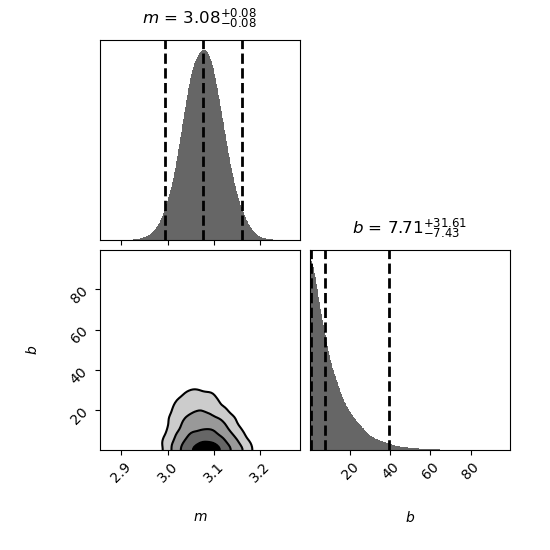

In [83]:
fig, axes = dyplot.cornerplot(dresults, show_titles=True,title_kwargs={'y': 1.04}, labels=['$m$','$b$'])

In [91]:
import scipy.stats as sts

def model(x, a, b):
    model = x*np.log(a*x+b)
    return model

# parameter theta drawn uniform distribution between zero and one.
def prior_transform(utheta):
    ua, ub = utheta
    a = 100*ua  # prior: m is between 0 and 10
    b = 100*ub  # prior: b is between 0 and 10
    return a, b

def lnlike(params):  # same parameter function?
    a, b = params
    y_val = model(x, a, b)
    return sum(sts.norm.logpdf(time_taken, loc=y_val, scale=100))


dsampler = dynesty.DynamicNestedSampler(lnlike, prior_transform, ndim=2)
dsampler.run_nested()
dresults = dsampler.results


24683it [01:57, 209.95it/s, batch: 11 | bound: 66 | nc: 1 | ncall: 60599 | eff(%): 40.732 | loglstar: -49.141 < -43.388 < -43.676 | logz: -57.643 +/-  0.231 | stop:  0.981]               


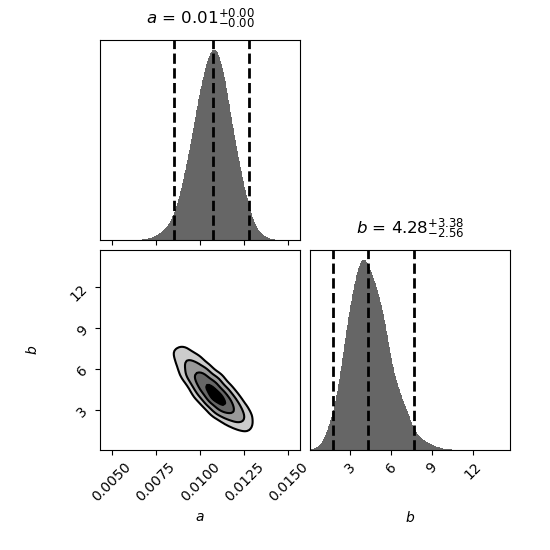

In [92]:
fig, axes = dyplot.cornerplot(dresults, show_titles=True,title_kwargs={'y': 1.04}, labels=['$a$','$b$'])

In [122]:
import scipy.stats as sts

def model(x, a, b, c):
    model = a*x**2 + b*x + c
    return model

# parameter theta drawn uniform distribution between zero and one.
def prior_transform(utheta):
    ua, ub, uc = utheta
    a = 1*ua  # prior: m is between 0 and 10
    b = 10*ub  # prior: b is between 0 and 10
    c = 100*uc
    return a, b, c

def lnlike(params):  # same parameter function?
    a, b, c = params
    y_val = model(x, a, b, c)
    return sum(sts.norm.logpdf(time_taken, loc=y_val, scale=100))


dsampler = dynesty.DynamicNestedSampler(lnlike, prior_transform, ndim=3)
dsampler.run_nested()
dresults = dsampler.results


24542it [01:59, 205.21it/s, batch: 11 | bound: 67 | nc: 2 | ncall: 64888 | eff(%): 37.822 | loglstar: -45.768 < -39.763 < -40.225 | logz: -52.880 +/-  0.219 | stop:  0.897]                  


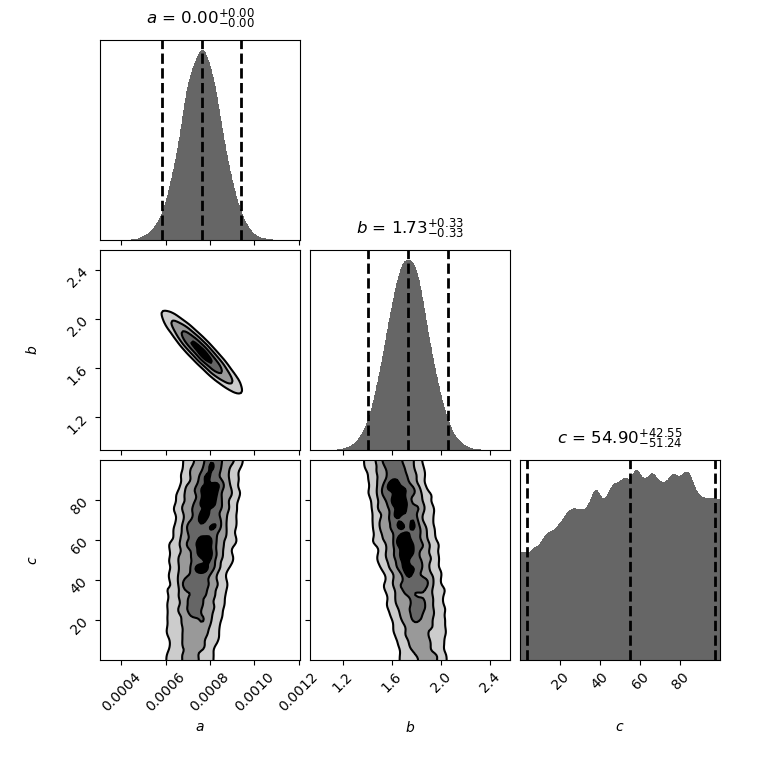

In [110]:
fig, axes = dyplot.cornerplot(dresults, show_titles=True,title_kwargs={'y': 1.04}, labels=['$a$','$b$','$c$'])

# Parallel

In [5]:
import scipy.stats as sts
import dynesty
import time
from dynesty import plotting as dyplot
from numpy import *

sigma = 0.01
restLambda = ang_freq_to_lambda(1)  # define ang_freq to be 1.
obsPolar = (0.7, 4)
time_taken = []
pol_true, az_true = obsPolar
logZ = []
log_Z0 = []
log_ZCMB = []
omega_val = 1
n = 200
obsSpeed = 0.001

xi, yi, zi = sample_spherical(n)
rotatedPoints, RGBs, obsLambda = transformedPoints(
    obsSpeed, sph2cart(obsPolar), restLambda, xi, yi, zi)

# list of Doppler shifted angular frequencies
obsAngFreq = lambda_to_ang_freq(obsLambda*10**(-9))
normalisedObsAngFreq = NormalizeData(obsAngFreq)

t0 = time.time()
## dynesty model fitting
# convert obsLambda in nm to m, then to angular frequency
omegas = lambda_to_ang_freq(obsLambda*10**(-9))
omega_error = np.random.normal(loc=0, scale=sigma, size=len(omegas))
omega_new = omegas + omega_error


In [6]:
ndim = 3

#change model to accept v, az, pol
def model(v, az, pol):
    observerVector = sph2cart((pol, az))
    alphaDash = determineAngleToObs(observerVector, rotatedPoints[0:len(
        rotatedPoints), 0], rotatedPoints[0:len(rotatedPoints), 1], rotatedPoints[0:len(rotatedPoints), 2])
    model = lambda_to_ang_freq(restLambda) * \
        (np.sqrt(1-v**2)/(1-v*np.cos(alphaDash)))
    return model

def prior_transform(uTheta):
    uV, uAz, uPol = uTheta
    v = 0.01*uV # uniform between 0 and 0.01
    az = 2*np.pi*uAz # uniform between 0 and 2*pi
    pol = np.pi*uPol # uniform between 0 and pi
    return v, az, pol

def lnlike(Theta):
    v, az, pol = Theta
    # turn az and pol into alpha' for this omega
    omega_val = model(v,az,pol)
    return sum(sts.norm.logpdf(omega_new,loc=omega_val,scale=sigma))

In [7]:
import ipyparallel as ipp

cl = ipp.Cluster(n=4)

rc = cl.start_and_connect_sync()
nprocs = len(rc.ids)
print(rc.ids)

dview = rc[:]
dview.use_dill()


Starting 4 engines with <class 'ipyparallel.cluster.launcher.LocalEngineSetLauncher'>


  0%|          | 0/4 [00:00<?, ?engine/s]

[0, 1, 2, 3]


<AsyncResult(use_dill): pending>

In [8]:
%%px

# import environment
from __future__ import division, print_function
from six.moves import range
import time, sys, os
import numpy as np
from numpy import linalg
import dynesty

# define likelihood (and prior?) constants
ndim = 3

# import colorcet as cc
# from matplotlib.widgets import Slider, Button
# import pandas
# from scipy.linalg import expm, norm
# import scipy.constants as sc
# import math
# import time
# from mpl_toolkits.mplot3d import axes3d
# import matplotlib.pyplot as plt
# from numpy import cross, eye, dot
# import numpy as np
# import traceback
# %matplotlib widget


# # Three variables drawn from Gaussian distribution

# def sample_spherical(npoints, ndim=3):
#     vec = np.random.randn(ndim, npoints)
#     vec /= np.linalg.norm(vec, axis=0)
#     return vec

# # Doppler shift a given angular frequency given angle to observer in source frame and observer's speed


# def doppler_shift(angFreq, obsAngle, obsSpeed):
#     # obsAngFreq = angFreq*((np.sqrt(1-obsSpeed**2)/(1 - obsSpeed*np.cos(obsAngle)))) #old function—used wrong equation
#     obsAngFreq = angFreq*((obsSpeed*np.cos(obsAngle)+1)/np.sqrt(1-obsSpeed**2))
#     return obsAngFreq


# def ang_freq_to_lambda(omega):
#     wavelength = sc.c/(2*math.pi*omega)
#     return wavelength


# def lambda_to_ang_freq(wavelength):
#     omega = sc.c/(2*math.pi*wavelength)
#     return omega


# def vectors_angle(v1, v2):
#     if (np.dot(v1, v2))/(np.linalg.norm(v1)*np.linalg.norm(v2)) <= 1 and (np.dot(v1, v2))/(np.linalg.norm(v1)*np.linalg.norm(v2)) >= -1:
#         return math.acos((np.dot(v1, v2))/(np.linalg.norm(v1)*np.linalg.norm(v2)))
#     elif (np.dot(v1, v2))/(np.linalg.norm(v1)*np.linalg.norm(v2)) < -1:
#         print('Less:' + str((np.dot(v1, v2))/(np.linalg.norm(v1)*np.linalg.norm(v2))))
#         return math.acos(-1)
#     elif (np.dot(v1, v2))/(np.linalg.norm(v1)*np.linalg.norm(v2)) > 1:
#         print('Greater:' + str((np.dot(v1, v2))/(np.linalg.norm(v1)*np.linalg.norm(v2))))
#         return math.acos(1)
    
#     # try:
#     #     angle = math.acos((np.dot(v1, v2))/(np.linalg.norm(v1)*np.linalg.norm(v2)))
#     #     # print((np.dot(v1, v2))/(np.linalg.norm(v1)*np.linalg.norm(v2)))
#     #     return angle
#     # except ValueError:
#     #     print((np.dot(v1, v2))/(np.linalg.norm(v1)*np.linalg.norm(v2)))
#     #     quit()


# def abberation_angle(angle, obsSpeed):
#     abberationAngle = math.acos(
#         (obsSpeed + math.cos(angle))/(obsSpeed*math.cos(angle)+1))
#     return abberationAngle


# def unit_norm_vector(v1, v2):
#     normVector = np.cross(v1, v2)
#     unitNormVector = normVector/np.linalg.norm(normVector)
#     return unitNormVector


# def rotateMatrix(axis, angle):
#     rotatedMatrix = expm(cross(eye(3), axis/norm(axis)*angle))
#     return rotatedMatrix


# def wavelength_to_rgb(wavelength, gamma=0.8):
#     '''This converts a given wavelength of light to an 
#     approximate RGB color value. The wavelength must be given
#     in nanometers in the range from 380 nm through 750 nm
#     (789 THz through 400 THz).

#     Based on code by Dan Bruton
#     http://www.physics.sfasu.edu/astro/color/spectra.html
#     '''

#     wavelength = float(wavelength)
#     if wavelength >= 380 and wavelength <= 440:
#         attenuation = 0.3 + 0.7 * (wavelength - 380) / (440 - 380)
#         R = ((-(wavelength - 440) / (440 - 380)) * attenuation) ** gamma
#         G = 0.0
#         B = (1.0 * attenuation) ** gamma
#     elif wavelength >= 440 and wavelength <= 490:
#         R = 0.0
#         G = ((wavelength - 440) / (490 - 440)) ** gamma
#         B = 1.0
#     elif wavelength >= 490 and wavelength <= 510:
#         R = 0.0
#         G = 1.0
#         B = (-(wavelength - 510) / (510 - 490)) ** gamma
#     elif wavelength >= 510 and wavelength <= 580:
#         R = ((wavelength - 510) / (580 - 510)) ** gamma
#         G = 1.0
#         B = 0.0
#     elif wavelength >= 580 and wavelength <= 645:
#         R = 1.0
#         G = (-(wavelength - 645) / (645 - 580)) ** gamma
#         B = 0.0
#     elif wavelength >= 645 and wavelength <= 750:
#         attenuation = 0.3 + 0.7 * (750 - wavelength) / (750 - 645)
#         R = (1.0 * attenuation) ** gamma
#         G = 0.0
#         B = 0.0
#     else:
#         R = 0.0
#         G = 0.0
#         B = 0.0
#     R *= 255
#     G *= 255
#     B *= 255
#     return [int(R), int(G), int(B)]


# def determineAngleToObs(obsVector, xi, yi, zi):
#     # angles between all vectors and observer vector from dot product
#     angles = []
#     for i in range(0, len(xi)):
#         angles.append(vectors_angle(obsVector, (xi[i], yi[i], zi[i])))
#     return angles


# def restLambdaToObsLambda(restLambda, angles, obsSpeed):
#     # lambda values as perceived by moving observer
#     restAngFreq = lambda_to_ang_freq(restLambda)
#     obsLambda = (ang_freq_to_lambda(
#         doppler_shift(restAngFreq, angles, obsSpeed)))
#     return obsLambda


# def wavelengthToRGB(obsLambda):
#     RGBs = []
#     for i in range(0, len(obsLambda)):
#         RGBs.append(wavelength_to_rgb(obsLambda[i]))
#     RGBs = np.asarray(RGBs, dtype=np.float32)
#     return RGBs


# def updatePoints(angles, obsSpeed, obsVector, xi, yi, zi):
#     ## Now we try to congregate points along the source of motion due to abberation
#     # angle difference
#     deltaAngles = []
#     for i in range(0, len(angles)):
#         deltaAngles.append(
#             -(abberation_angle(angles[i], obsSpeed) - angles[i]))
#     # normal vector/rotation axes
#     rotAxes = []
#     for i in range(0, len(angles)):
#         rotAxes.append(unit_norm_vector((xi[i], yi[i], zi[i]), obsVector))
#     rotationMatrices = []
#     for i in range(0, len(rotAxes)):
#         rotationMatrices.append(rotateMatrix(rotAxes[i], deltaAngles[i]))
#     rotatedPoints = []
#     for i in range(0, len(rotationMatrices)):
#         rotatedPoints.append(dot(rotationMatrices[i], (xi[i], yi[i], zi[i])))
#     rotatedPoints = np.asarray(rotatedPoints, dtype=np.float32)
#     return rotatedPoints


# def transformedPoints(obsSpeed, obsVector, restLambda, xi, yi, zi):
#     angles = determineAngleToObs(obsVector, xi, yi, zi)
#     obsLambda = restLambdaToObsLambda(restLambda, angles, obsSpeed)*10**9
#     RGBs = wavelengthToRGB(obsLambda)
#     rotatedPoints = updatePoints(angles, obsSpeed, obsVector, xi, yi, zi)
#     return rotatedPoints, RGBs, obsLambda


# def cart2sph(obsVector):
#     hxy = np.hypot(obsVector[0], obsVector[1])
#     if obsVector[2] == 0:
#         theta = np.pi/2
#     else:
#         theta = np.arccos(
#             obsVector[2]/math.sqrt(obsVector[0]**2 + obsVector[1]**2 + obsVector[2]**2))
#     if obsVector[0] > 0:
#         atan = np.arctan(obsVector[1]/obsVector[0])
#         phi = atan
#     elif obsVector[0] < 0 and obsVector[1] >= 0:
#         atan = np.arctan(obsVector[1]/obsVector[0])
#         phi = atan + np.pi
#     elif obsVector[0] < 0 and obsVector[1] < 0:
#         atan = np.arctan(obsVector[1]/obsVector[0])
#         phi = atan - np.pi
#     elif obsVector[0] == 0 and obsVector[1] > 0:
#         phi = np.pi/2
#     elif obsVector[0] == 0 and obsVector[1] < 0:
#         phi = -np.pi/2
#     elif obsVector[0] == 0 and obsVector[1] == 0:
#         phi = 0
#     return (theta, phi)


# def sph2cart(obsPolar):  # r=1
#     x = np.sin(obsPolar[0]) * np.cos(obsPolar[1])
#     y = np.sin(obsPolar[0]) * np.sin(obsPolar[1])
#     z = np.cos(obsPolar[0])
#     return (x, y, z)


# def NormalizeData(data):
#     return (data - np.min(data)) / (np.max(data) - np.min(data))

# sigma = 0.01
# restLambda = ang_freq_to_lambda(1)  # define ang_freq to be 1.
# obsPolar = (0.7, 4)
# obsSpeed = 0.001
# time_taken = []
# pol_true, az_true = obsPolar
# logZ = []
# log_Z0 = []
# log_ZCMB = []
# omega_val = 1
# n = 100

# xi, yi, zi = sample_spherical(n)
# rotatedPoints, RGBs, obsLambda = transformedPoints(
#     obsSpeed, sph2cart(obsPolar), restLambda, xi, yi, zi)

# # list of Doppler shifted angular frequencies
# obsAngFreq = lambda_to_ang_freq(obsLambda*10**(-9))
# normalisedObsAngFreq = NormalizeData(obsAngFreq)

# # convert obsLambda in nm to m, then to angular frequency
# omegas = lambda_to_ang_freq(obsLambda*10**(-9))
# omega_error = np.random.normal(loc=0, scale=sigma, size=len(omegas))
# omega_new = omegas + omega_error

# seed the random number generator
np.random.seed(os.getpid())
print('Random seed:',os.getpid())


[stdout:1] Random seed: 4520


[stdout:2] Random seed: 18180


[stdout:3] Random seed: 10504


[stdout:0] Random seed: 20804


In [9]:
class Pool(object):
    """A simple wrapper for `dview`."""

    def __init__(self, dview):
        self.dview = dview
        self.size = len(rc.ids)

    def map(self, function, tasks):
        return self.dview.map_sync(function, tasks)

# define our pool
pool = Pool(dview)


In [10]:
import dynesty

dsampler = dynesty.DynamicNestedSampler(
    lnlike, prior_transform, ndim, pool=pool)
dsampler.run_nested()


0it [00:00, ?it/s]